In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import deque, namedtuple
import torch.nn.functional as F
import torch.utils.data as Data
from timeit import default_timer as timer
import random
from scipy import signal
from classifier_cnn import addNoise2Batch

In [5]:
##Process mat data
import pandas as pd
SDRdatasets=[]
SDRtargets=[]
nSDR=11
samples_perSDR=300
distanceProcessed=0.5
reader=pd.read_excel('../ML/propossedData/SDRDataTarget.xlsx')
cols=reader.keys()
files=reader[cols[0]]
distances=reader[cols[1]]
sizes=reader[cols[2]]
labels=reader[cols[3]]
for i in range(len(files)):
    file, distance, label = files[i], distances[i], labels[i]
    if not np.isnan(label) and distance==distanceProcessed:
        print(distance, label)
        data=scipy.io.loadmat('../ML/propossedData/'+str(distanceProcessed)+"meters/"+file)['packet_equalized_allrecord']
        data = data[:300]
        for sigIdx in range(300):
            data[sigIdx]=-1+2*((data[sigIdx] - data[sigIdx].min())/(data[sigIdx].max() - data[sigIdx].min()))
        SDRdatasets.append(data)
        SDRtargets.append(label*np.ones(samples_perSDR))

SDRdatasets=np.array(SDRdatasets)
SDRtargets=np.array(SDRtargets)
print("SDRdatasets shape: ", SDRdatasets.shape)
print("SDRtargets shape: ", SDRtargets.shape)

SDRdatasets=SDRdatasets.reshape((-1, 2, 800))
SDRtargets=SDRtargets.reshape((-1,1))
print("SDRdatasets shape: ", SDRdatasets.shape)
print("SDRtargets shape: ", SDRtargets.shape)
for i in range(nSDR):
    print(SDRtargets[i*300])

# SDRdatasets = -1+2*(SDRdatasets-SDRdatasets.min())/(SDRdatasets.max()-SDRdatasets.min())

SDRdict = {"datasets": SDRdatasets, "targets": SDRtargets}
np.save('../ML/propossedData/SDRDataset_'+str(distanceProcessed)+"meters_"+str(nSDR)+"SDR_300samples_normseperate_len800.npy", SDRdict)

0.5 0.0
0.5 1.0
0.5 2.0
0.5 3.0
0.5 4.0
0.5 5.0
0.5 6.0
0.5 7.0
0.5 8.0
0.5 9.0
0.5 10.0
SDRdatasets shape:  (11, 300, 2, 800)
SDRtargets shape:  (11, 300)
SDRdatasets shape:  (3300, 2, 800)
SDRtargets shape:  (3300, 1)
[0.]
[1.]
[2.]
[3.]
[4.]
[5.]
[6.]
[7.]
[8.]
[9.]
[10.]


1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0


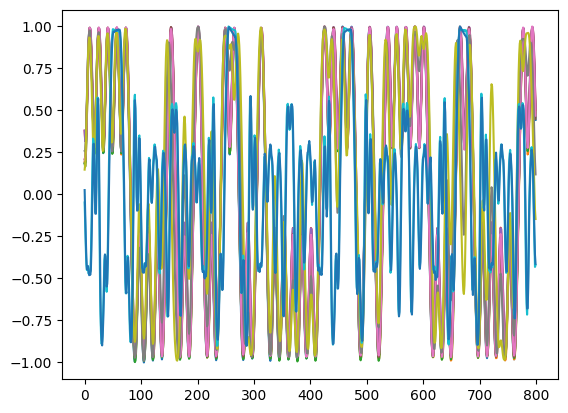

In [4]:
for i in range(nSDR):
    plt.plot(SDRdatasets[i*300][1])
    print(SDRdatasets[i*300].max(), SDRdatasets[i*300].min())

print(SDRdatasets.max(), SDRdatasets.min())

In [2]:
class ClassifierSDR(nn.Module):
    def __init__(self, nSDR):
        super().__init__()

        #For 800 length 
        self.conv0 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=5,stride=1, padding=2) # => 8*800
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1, padding=2) # => 8*800
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=8,stride=2, padding=3) # => 16*400
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=6, stride=2, padding=2) # => 16*200

        self.linear1 = nn.Linear(in_features=32*200, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=nSDR)

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):

        #For 800 length 
        x=F.relu(self.conv0(x))
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))

        # x=self.maxpool1(x)
        flatten = nn.Flatten()
        x=flatten(x)
        x=F.relu(self.linear1(x))
        x=self.linear2(x)

        return x

In [17]:
def train(nSDR, net, n_epochs, lr, batchsize,trainLoader, valLoader, testLoader,device, snr, noise):
    n_epochs=n_epochs
    optimizer = optim.Adam(net.parameters(), lr=lr)
    trainLoss_curve=[]
    trainAcc_curve=[]
    trainAccDict_curve=[]
    valLoss_curve=[]
    valAcc_curve=[]
    valAccDict_curve=[]
    for epoch in range(n_epochs):
        # print("epoch: ", epoch)
        net.train()
        train_loss = 0
        train_acc = 0
        train_acc_dict = torch.zeros((nSDR,2)).to(device)
        val_loss = 0
        val_acc=0
        val_acc_dict = torch.zeros((nSDR,2)).to(device)
        loss = None
        for batch_idx, (data, labels) in enumerate(trainLoader):
            data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)
            optimizer.zero_grad()
            labels_ = net.forward(data)
            loss = F.cross_entropy(labels_, labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
            labels_ = torch.argmax(labels_, dim=1)
            train_acc+=(sum(labels_==labels)/batchsize)
            for i in range(batchsize):
                label=labels[i]
                train_acc_dict[label][0]+=1
                if labels_[i]==label:
                    train_acc_dict[label][1]+=1
            

        for batch_idx, (data, labels) in enumerate(valLoader):
            data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)
            optimizer.zero_grad()
            labels_ = net.forward(data)
            loss = F.cross_entropy(labels_, labels)
            loss.backward()
            optimizer.step()
            val_loss+=loss.item()
            labels_ = torch.argmax(labels_, dim=1)
            val_acc+=(sum(labels_==labels)/batchsize)
            for i in range(batchsize):
                label=labels[i]
                val_acc_dict[label][0]+=1
                if labels_[i]==label:
                    val_acc_dict[label][1]+=1

        train_loss = train_loss/len(trainLoader)
        trainLoss_curve.append(train_loss)
        train_acc = train_acc/len(trainLoader)
        trainAcc_curve.append(train_acc.item())

        val_loss = val_loss/len(valLoader)
        valLoss_curve.append(val_loss)
        val_acc = val_acc/len(valLoader)
        valAcc_curve.append(val_acc.item())
        
        train_acc_spt = torch.round(train_acc_dict[:,1]/train_acc_dict[:,0], decimals=4)
        val_acc_spt = torch.round(val_acc_dict[:,1]/val_acc_dict[:,0], decimals=4)
        if (epoch+1)%100==0:
            print('\nEpoch: {} \tTraining Loss: {:.6f}, Training Acc: {:.6f}'.format(epoch, train_loss, train_acc))
            print('Epoch: {} \tValidation Loss: {:.6f}, Validation Acc: {:.6f}'.format(epoch, val_loss, val_acc))
            print("Train acc_dic \t{}".format(train_acc_spt.detach().cpu().numpy()))
            print("Val acc_dic \t{}".format(val_acc_spt.detach().cpu().numpy()))
            # checkpoint_path="./checkpoint/ClassifierSDR/11SDR_normseperate_epoch"+str(epoch+1)+".cnn"
            # torch.save({
            #     "epoch": epoch,
            #     'lr': lr,
            #     'batch_size': batchsize,
            #     'optimizer': optimizer,
            #     'classifier': net,
            #     'train_acc': train_acc,
            #     'val_acc': val_acc,
            # }, checkpoint_path)

    # test
    test_acc=0
    test_acc_dict = torch.zeros((nSDR,2)).to(device)
    for batch_idx, (data, labels) in enumerate(testLoader):
        data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)
        optimizer.zero_grad()
        labels_ = net.forward(data)
        labels_ = torch.argmax(labels_, dim=1)
        test_acc+=(sum(labels_==labels)/batchsize)
        for i in range(batchsize):
            label=labels[i]
            test_acc_dict[label][0]+=1
            if labels_[i]==label:
                test_acc_dict[label][1]+=1

    test_acc = test_acc/len(testLoader)

    test_acc_spt = torch.round(test_acc_dict[:,1]/test_acc_dict[:,0], decimals=4)
    print('Test Acc: {:.6f}'.format(test_acc))
    print("Test acc_dic \t{}".format(test_acc_spt.detach().cpu().numpy()))

    # if save model
    if not noise:
        checkpoint_path="./checkpoint2/classifier/11SDR_nosnr_normall_epoch"+str(n_epochs)+".cnn"
    else:
        checkpoint_path="./checkpoint2/classifier/11SDR_nosnr_normall_epoch"+str(n_epochs)+".cnn"
    # torch.save({
    #     "epoch": epoch,
    #     'lr': lr,
    #     'batch_size': batchsize,
    #     'optimizer': optimizer,
    #     'classifier': net,
    #     'train_acc': train_acc,
    #     'val_acc': val_acc,
    #     'test_acc': test_acc 
    # }, checkpoint_path)
    

    train_acc_spt = train_acc_spt.detach().cpu().numpy()
    val_acc_spt = val_acc_spt.detach().cpu().numpy()
    test_acc_spt = test_acc_spt.detach().cpu().numpy()

    plt.figure()
    plt.plot(trainLoss_curve, label="Train Loss")
    plt.plot(valLoss_curve, label="Val Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.figure()
    plt.plot(trainAcc_curve, label="Train")
    plt.plot(valAcc_curve, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.show()

    plt.figure()
    plt.plot(train_acc_spt, label="Train Acc {:.2f}%".format(train_acc*100))
    plt.plot(val_acc_spt, label="Validation Acc {:.2f}%".format(val_acc*100))
    plt.plot(test_acc_spt, label="Test Acc {:.2f}%".format(test_acc*100))
    plt.legend()
    plt.xlabel("RFF")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs RFFs")
    plt.show()


SDR: 0, range: -1.0834280810020824~1.0922980155522182
SDR: 1, range: -1.058383509109785~1.0845641892287132
SDR: 2, range: -1.066407171391747~1.0792721002948629
SDR: 3, range: -1.1897689227070747~1.0920920184403378
SDR: 4, range: -1.1869443250918366~1.0917339509025332
SDR: 5, range: -1.0862636185959096~1.0812231466091955
SDR: 6, range: -1.0734850937523501~1.0840441034873072
SDR: 7, range: -1.2601737915594606~1.278340674837508
SDR: 8, range: -1.48801561243046~1.5057799732688084
SDR: 9, range: -8.785159664297002~8.741891303915114
SDR: 10, range: -7.755087462490059~8.205938968160432
datasets load all sdr shape:  (3300, 2, 800)
targets load all sdr shape:  (3300,)
datasets load all sdr range: -8.785159664297002~8.741891303915114
noise = False
datasets add no snr and normed range: -1.0~0.995074835058749
datasets_total shape:  (3300, 2, 800)
targets_total:  (3300,)

Epoch: 99 	Training Loss: 0.415005, Training Acc: 0.789126
Epoch: 99 	Validation Loss: 0.408258, Validation Acc: 0.810976
Train 

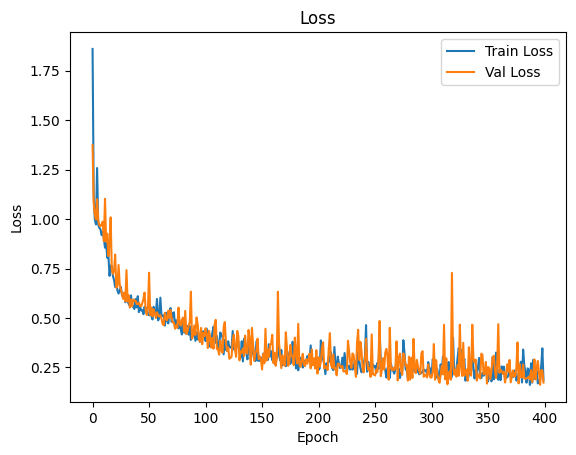

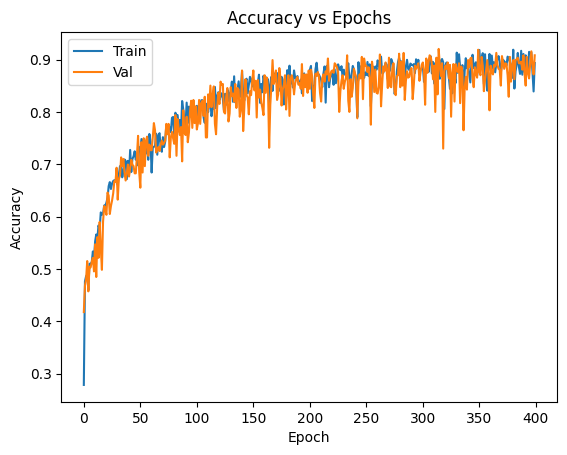

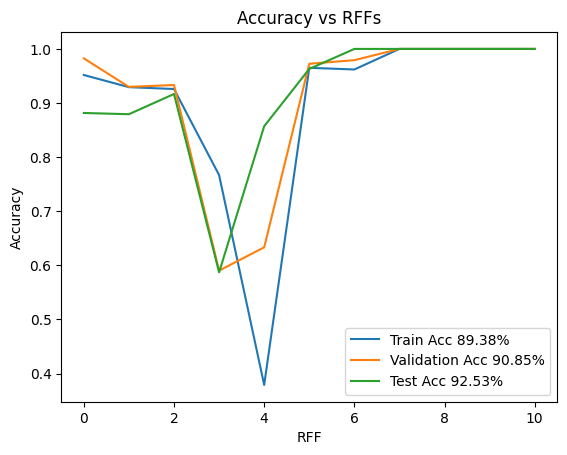

In [19]:
from GAN_SDR_test50 import load_allSDR_norm, matFiles50, matFiles25
distanceProcessed=0.25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

matFiles=["pluto1_0.25meters_run2.mat",
    "pluto2_0.25meters_run2.mat",
    "pluto3_0.25meters_run2.mat",
    "AD9082_0.25meters_run2.mat",
    "AD9082_CC2595_amp1_0.25meters_run2.mat",
    "TI_TRF3705_0.25meters.mat",
    "TI_TRF3705_CC2595_amp1_0.25meters.mat",
    "TI_TRF3722_CC2595_amp1_0.25meters.mat",
    "TI_TRF3722_0.25meters.mat",
    "Pluto1RX_9082TX_0.25meters_NoAGC10Gain_3pkthreshold_348samples.mat",
    "Pluto1RX_9082_CC2595_TX_0.25meters_3pkthreshold_582samples.mat"]

datasets=None
targets=None
samples_perSDR=300
for matfilei in range(len(matFiles)):
    matfile = matFiles[matfilei]
    datasets_load=scipy.io.loadmat("./propossedData/0.25meters/"+matfile)['packet_equalized_allrecord']
    datasets_load = datasets_load[:samples_perSDR]
    targets_load = matfilei*np.ones(datasets_load.shape[0])
    print("SDR: {}, range: {}~{}".format(matfilei, datasets_load.min(), datasets_load.max()))
    datasets = np.concatenate([datasets, datasets_load], axis=0) if matfilei!=0 else datasets_load
    targets = np.concatenate([targets, targets_load], axis=0) if matfilei!=0 else targets_load
print("datasets load all sdr shape: ", datasets.shape)
print("targets load all sdr shape: ", targets.shape)
print("datasets load all sdr range: {}~{}".format(datasets.min(), datasets.max()))

noise = False
snrs = [35, 30, 25, 20, 15, 10, 5]
nSDR=11
print("noise =", noise)
if noise:
    datasets_total=None
    targets_total=None
    for snr in snrs:
        datasets_noised = addNoise2Batch(datasets, snr, norm=False, device=device) #np array
        print("add snr: {}, datasets range: {}~{}".format(snr, datasets_noised.min(), datasets_noised.max()))
        datasets_total = np.concatenate([datasets_total, datasets_noised], axis=0) if snr!=35 else datasets_noised
        targets_total = np.concatenate([targets_total, targets], axis=0) if snr!=35 else targets
    datasets_total = np.array(datasets_total)
    targets_total=np.array(targets_total)
    print("datasets add all snr range: {}~{}".format(datasets_total.min(), datasets_total.max()))
    datasets_total_magn = np.max((np.abs(datasets_total.min()), np.abs(datasets_total.max())))
    datasets_total = datasets_total/datasets_total_magn
    print("datasets add all snr and normed range: {}~{}".format(datasets_total.min(), datasets_total.max()))
else:
    datasets_total, targets_total = datasets, targets
    datasets_total_magn = np.max((np.abs(datasets_total.min()), np.abs(datasets_total.max())))
    datasets_total = datasets_total/datasets_total_magn
    print("datasets add no snr and normed range: {}~{}".format(datasets_total.min(), datasets_total.max()))
print("datasets_total shape: ", datasets_total.shape)
print("targets_total: ", targets_total.shape)
np.random.seed(0)
datasets, targets = torch.tensor(datasets_total), torch.tensor(targets_total)
# targets = targets.type(torch.DoubleTensor)
SDRdatasets=Data.TensorDataset(datasets, targets)
train_set, val_set, test_set = Data.random_split(SDRdatasets, [0.6, 0.2, 0.2])

batch_size = 16
n_epochs = 400
lr= 1e-3   #1e-3
trainLoader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valLoader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)
# testLoader = Data.DataLoader(rffTest, batch_size=batch_size, shuffle=True, drop_last=True)
n_harmonics=datasets.shape[1]

net = ClassifierSDR(nSDR=nSDR).to(device)
train(net=net, nSDR=nSDR, n_epochs=n_epochs, lr=lr, batchsize=batch_size,trainLoader=trainLoader, valLoader=valLoader, testLoader=testLoader,device=device, snr = snr, noise=noise)

In [20]:
from GAN_SDR_test50 import load_allSDR_norm, matFiles50, matFiles25
distanceProcessed=0.25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_noise = False
snrs = [35, 30, 25, 20, 15, 10, 5]
nSDR=11
batch_size = 16
print("test noise =", test_noise)

classifier = ClassifierSDR(nSDR=nSDR)
clf_load=torch.load("./checkpoint2/classifier/11SDR_nosnr_normall_epoch200.cnn", map_location=device)
classifier=clf_load["classifier"]
train_acc=clf_load["train_acc"]
val_acc=clf_load["val_acc"]
test_acc=clf_load["test_acc"]
print("Load clf, train_acc:{:.2f}%, val_acc:{:.2f}%, test_acc:{:.2f}%".format(train_acc.item()*100, val_acc.item()*100, test_acc.item()*100))

datasets=None
targets=None
samples_perSDR=300
datasets_allSDR, targets_allSDR = load_allSDR_norm(matFiles50, distance=0.5)

datasets_allSDR = datasets_allSDR[:9*samples_perSDR]
targets_allSDR = targets_allSDR[:9*samples_perSDR]

for snr in snrs:
    np.random.seed(345)
    datasets_total, targets_total = addNoise2Batch(datasets_allSDR, snr=snr, norm=False), targets_allSDR
    print("datasets_total shape: ", datasets_total.shape)
    print("targets_total: ", targets_total.shape)
    datasets, targets = torch.tensor(datasets_total), torch.tensor(targets_total)

    SDRdatasets=Data.TensorDataset(datasets, targets)
    train_set, val_set, test_set = Data.random_split(SDRdatasets, [0.6, 0.2, 0.2])
    testLoader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # test
    test_acc=0
    test_acc_dict = torch.zeros((nSDR,2)).to(device)
    for batch_idx, (data, labels) in enumerate(testLoader):
        data, labels = data.to(device, dtype=torch.float), labels.to(device,  dtype=torch.int64)
        labels_ = classifier.forward(data)
        labels_ = torch.argmax(labels_, dim=1)
        test_acc+=(sum(labels_==labels)/batch_size)
        for i in range(batch_size):
            label=labels[i]
            test_acc_dict[label][0]+=1
            if labels_[i]==label:
                test_acc_dict[label][1]+=1

    test_acc = test_acc/len(testLoader)

    test_acc_spt = torch.round(test_acc_dict[:,1]/test_acc_dict[:,0], decimals=4)
    print("snr:{}dB".format(snr))
    print('Test Acc: {:.6f}'.format(test_acc))
    print("Test acc_dic \t{}\n".format(test_acc_spt.detach().cpu().numpy()))

test noise = False
Load clf, train_acc:96.09%, val_acc:94.97%, test_acc:89.94%
datasets_total shape:  (2700, 2, 800)
targets_total:  (2700,)
snr:35dB
Test Acc: 0.354167
Test acc_dic 	[0.0317 0.2759 0.1014 0.6304 0.2545 0.     0.098  1.     1.        nan
    nan]

datasets_total shape:  (2700, 2, 800)
targets_total:  (2700,)
snr:30dB
Test Acc: 0.397727
Test acc_dic 	[0.2414 0.339  0.1333 0.5    0.3051 0.     0.0345 1.     1.        nan
    nan]

datasets_total shape:  (2700, 2, 800)
targets_total:  (2700,)
snr:25dB
Test Acc: 0.378788
Test acc_dic 	[0.2963 0.1875 0.1774 0.3509 0.3433 0.     0.069  0.9825 1.        nan
    nan]

datasets_total shape:  (2700, 2, 800)
targets_total:  (2700,)
snr:20dB
Test Acc: 0.323864
Test acc_dic 	[0.5672 0.1    0.2143 0.1692 0.0769 0.     0.0476 0.9362 0.9811    nan
    nan]

datasets_total shape:  (2700, 2, 800)
targets_total:  (2700,)
snr:15dB
Test Acc: 0.327652
Test acc_dic 	[0.6444 0.0323 0.2727 0.0339 0.0816 0.0484 0.     0.9355 0.9661    nan
    na